# 순서

1. 데이터의 특징
2. 모델을 평가하는데 가장 적합한 metric 과 그 이유
3. 적용한 기술 및 모델 튜닝 방법
4. Key Point(중요했던 부분)
5. Hurdle Point(미흡하거나 어려웠던 부분)
6. 레퍼런스 논문들

# 1.EDA

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('./recommendation_dataset/user_train.csv')

## 물품들의 판매 갯수
아리 분포 그래프를 부면 전형적인 긴 꼬리 형태로 대부분 조회 횟수가 40회 미만입니다

In [ ]:
user_pick_count_df = df.groupby('user_id').size().reset_index().rename(columns = {0: 'count'})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


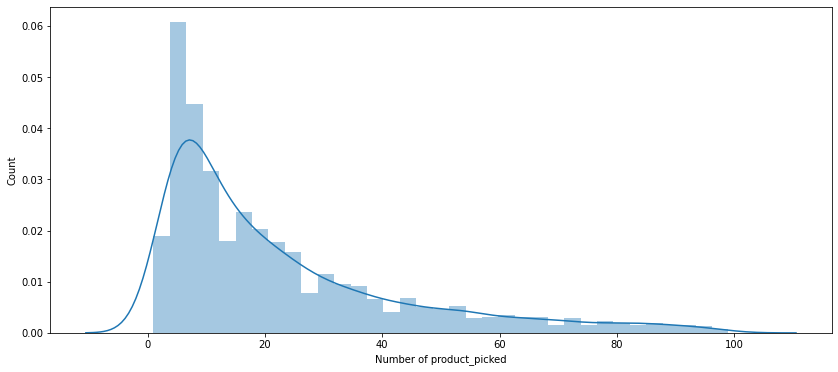

In [ ]:
plt.figure(figsize = (14, 6))
sns.distplot(user_pick_count_df[user_pick_count_df['count'] < 100]['count'])
plt.xlabel('Number of product_picked')
plt.ylabel('Count')
plt.show()

In [ ]:
product = pd.read_csv('./recommendation_dataset/product.csv')

In [ ]:
product

,Unnamed: 0,description,product_id,price,low_price
0,0,모그 핑크에디션 린넨 100 여성 티블라우스 3종,b3 1046 b2 711864 4 52b86f b 290b 64f093 048 b...,79000,78000
1,1,gs단독방송 파오 pao 페이셜 피트니스,378 033f98466282b 6 7 1 b14f1 f8 8bb6f bf4115 ...,138000,124200
2,2,트라이엄프 슬로기 제로필 볼륨 여성속옷 브라팬티 8종세트,544 814338 218 5b3908 404f178027b249 2 4 77 b23,79000,78000
3,3,as98 에이에스98 파니아 프리미엄 웨지샌들 t y,142b1 66702 12 51525 1466660 8720 79 b 2499713...,138000,128000
4,4,all made in italy a s 98 파니아 이태리 웨지힐,829f12241 8 0816391 09 42884 f b1b8 01086 97 9...,138000,137000
...,...,...,...,...,...
56082,56082,노스페이스화이트라벨 여성용 카로나 워터 레깅스 all nyf6ki39 all,8ff6b9 67655244f9 4085 474182 961f 8048 193 5b...,40000,40000
56083,56083,캔마트 라벨무지라운드티 c051501,83 9f7 6f1023857 9 f 742f461f345 8 f4289 2 9 9...,8000,8000
56084,56084,노스페이스에디션 노스페이스 에디션 w’s lansing zip up jac,1804199 f08 f 9 0 342 91 241 71 6710 34 5741105,39000,39000
56085,56085,lazybee 코르셋1703 여성 래쉬가드 이너웨어,3095 226057 54b 451947 817 f39 099 37969bb4 95...,19800,15840


## 할인가의 영향
밑의 히스토리그램으로 볼수있듯 할인을 하였다해서 드라마틱한 변화는 일어나지 않습니다.

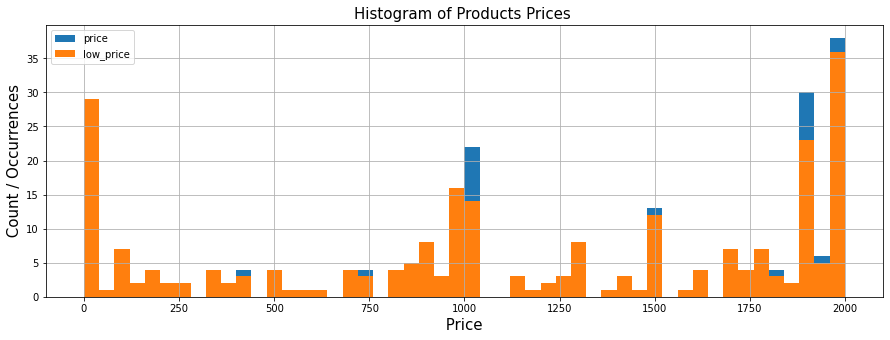

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(product['price'], bins=50, range=[0,2000], label="price")
ax.hist(product['low_price'], bins=50, range=[0,2000], label="low_price")
plt.title("Histogram of Products Prices ", fontsize=15)
plt.xlabel(' Price ', fontsize=15)
plt.ylabel(' Count / Occurrences ', fontsize=15)
plt.grid()
plt.legend()
plt.show()

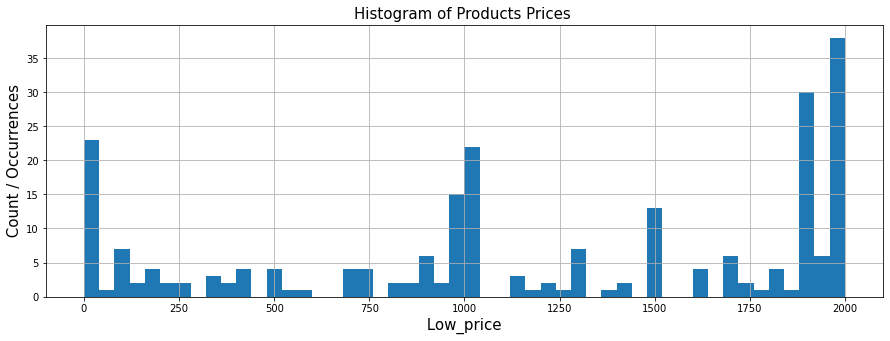

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(product['price'], bins=50, range=[0,2000], label="Price")
plt.title("Histogram of Products Prices ", fontsize=15)
plt.xlabel(' Low_price ', fontsize=15)
plt.ylabel(' Count / Occurrences ', fontsize=15)
plt.grid()
plt.show()

## 물건들의 가격 분포
물건들의 가격 분포를 보면 상위로 갈수록 가격편차가 심하여 평균과 중간값의 차이가 클것입니다.

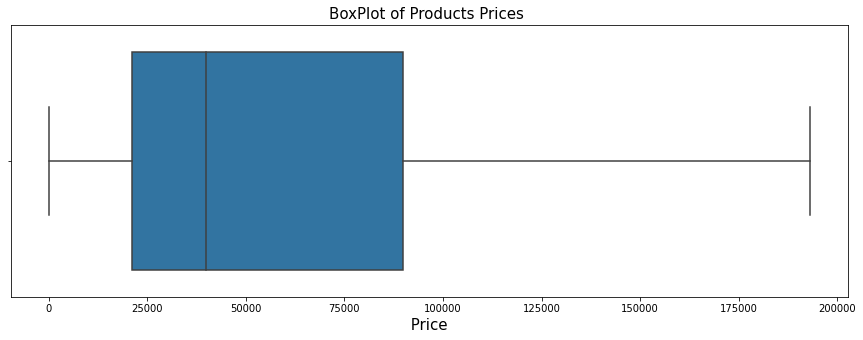

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='price', data=product ,showfliers=False)
plt.title("BoxPlot of Products Prices ", fontsize=15)
plt.xlabel(' Price ', fontsize=15)
plt.show()

## 가격과 상품명의 길이 사이의 관계
밑의 그림과 같이 가격과 상품명의 길이 사이의 관계를 보면 1 ~ 10 까지의 길이는 가격이 오를수록 상품명의 길이가 길어지는것을 볼수 있고 그 밖에 길이는 영향을 끼치지 않습니다.

In [ ]:
import re
import string

In [ ]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") if len(w)>=3]
        return len(words)
    except: 
        return 0

In [ ]:
product['description_len'] = product['description'].apply(lambda x: len([w for w in x.split(" ") if len(w) >= 3]))

In [ ]:
product

,Unnamed: 0,description,product_id,price,low_price,description_len
0,0,모그 핑크에디션 린넨 100 여성 티블라우스 3종,b3 1046 b2 711864 4 52b86f b 290b 64f093 048 b...,79000,78000,3
1,1,gs단독방송 파오 pao 페이셜 피트니스,378 033f98466282b 6 7 1 b14f1 f8 8bb6f bf4115 ...,138000,124200,4
2,2,트라이엄프 슬로기 제로필 볼륨 여성속옷 브라팬티 8종세트,544 814338 218 5b3908 404f178027b249 2 4 77 b23,79000,78000,6
3,3,as98 에이에스98 파니아 프리미엄 웨지샌들 t y,142b1 66702 12 51525 1466660 8720 79 b 2499713...,138000,128000,5
4,4,all made in italy a s 98 파니아 이태리 웨지힐,829f12241 8 0816391 09 42884 f b1b8 01086 97 9...,138000,137000,6
...,...,...,...,...,...,...
56082,56082,노스페이스화이트라벨 여성용 카로나 워터 레깅스 all nyf6ki39 all,8ff6b9 67655244f9 4085 474182 961f 8048 193 5b...,40000,40000,7
56083,56083,캔마트 라벨무지라운드티 c051501,83 9f7 6f1023857 9 f 742f461f345 8 f4289 2 9 9...,8000,8000,3
56084,56084,노스페이스에디션 노스페이스 에디션 w’s lansing zip up jac,1804199 f08 f 9 0 342 91 241 71 6710 34 5741105,39000,39000,7
56085,56085,lazybee 코르셋1703 여성 래쉬가드 이너웨어,3095 226057 54b 451947 817 f39 099 37969bb4 95...,19800,15840,4


In [ ]:
price = product.groupby('description_len')['price'].mean().reset_index()

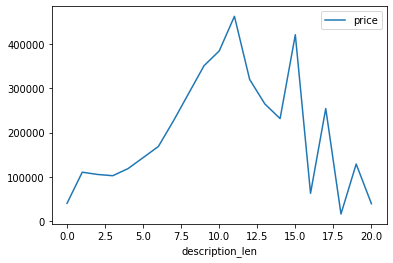

In [ ]:
price.plot(x = 'description_len',y = 'price')

## 판매와 상품의 길이 사이의 관계
아래 그림과 같이 상품명의 길이가  2.5 ~ 7.5 사이가 판매의 대부분을 차지하고 있습니다.  

In [ ]:
product_picked = product.groupby('description_len').sum().reset_index()

In [ ]:
product_picked  = product_picked.rename(columns= {'Unnamed: 0' : 'count'})

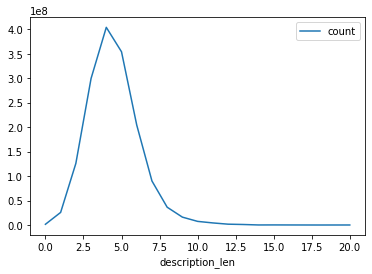

In [ ]:
product_picked.plot(x = 'description_len',y = 'count')

## 시간에 따른 품목의 판매량
시간에 따라 품목의 판매가 영향이 끼치는지 를 보면
아래의 그림과 같이 시간이 지날수록 판매가 급격하게 낮아지는것을 확인할수 있었습니다.

In [ ]:
df['dates'] = pd.to_datetime(df['data'], format='%Y%m%d%H%M%S')

In [ ]:
new_df = df.set_index('dates')

In [ ]:
new_df['data'].max()

20180731235920

In [ ]:
new_df.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135990 entries, 2018-07-01 12:59:05 to 2018-07-21 08:43:10
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     135990 non-null  object
 1   product_id  135990 non-null  object
 2   data        135990 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
time_df = new_df.resample('D').sum()

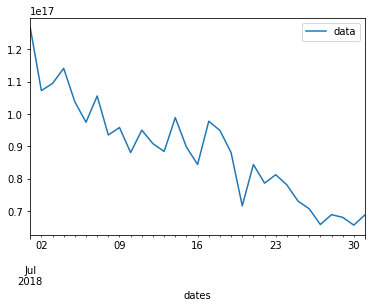

In [ ]:
time_df.plot()

## 결론 
* 상품의 길이가 2.5 ~ 7.5 사이가 판매가 가장 좋다
* 상품의 최신성이 중요하다
* 할인은 영향을 끼치지 않는다.

# 2. 모델을 평가하기에 가장 적합한 Metric 및 이유


## 저는 이 모델을 평가하는데 가장 적합한 metric 는 MRR(mean reciprocal rank)고 생각합니다. 
그 이유는 보통 머신러닝 모델 성능 평가 할때 precision,  recall, accuary 등을 사용하는데 추천시스템에서는  결과가 여러개 나오고, 이를 쓰기에는 불편한 점이 있습니다.
MRR 은 여러개의 query로 평가하고 점수들의 평균을 취한 값이 mrr 이어서 추천시스템에 어울리는 모델 평가 수단입니다. 

# 3.적용한 기술 및 모델 튜닝 방법

## 적용한 기술은 세션 기반 협업 필터링을 썻습니다.
그 이유는 앞선 EDA 에서 아이템의 최신성에 크게 영향을 끼치는 홈쇼핑의 구조상 이용 패턴에 적합한 추천 기술로 판단하였습니다.
또한 item2vec 기반 추천 시스템을 도입해 보았으나 성능이 세션 기반 협업 필터링 보다 떨어져 제외 하였습니다.

## 모델 튜닝 방법

Args:
    --loss_type: Loss function type. Should be one of the 'TOP1', 'BPR', 'CrossEntropy'.(Default: 'TOP1')

    --model_name: The prefix for the intermediate models that will be stored during the training.(Default: 'GRU4REC')

    --hidden_size: The dimension of the hidden layer of the GRU.(Default: 100)

    --num_layers: The number of layers for the GRU.(Default: 1)

    --batch_size: Training batch size.(Default: 50)

    --dropout_input: Dropout probability of the input layer of the GRU.(Default: 0)

    --dropout_hidden: Dropout probability of the hidden layer of the GRU.(Default: .5)

    --optimizer_type: Optimizer type. Should be one of the 'Adagrad', 'RMSProp', 'Adadelta', 'Adam', 'SGD'(Default: 'Adagrad')

    --lr: Learning rate for the optimizer.(Default: 0.01)

    --weight_decay: Weight decay for the optimizer.(Default: 0)

    --momentum: Momentum for the optimizer.(Default: 0)

    --eps: eps parameter for the optimizer.(Default: 1e-6)

    --n_epochs: The number of training epochs to run.(Default: 10)
    
    --time_sort: Whether to sort the sessions in the dataset in a time order.(Default: False)

해당 시범 코드는 example.ipynb 에서 확인할수 있습니다

# 4. Key Point


## 제가 가장 중요하게 생각했던 부분은 loss 부분으로써 TOP1-max 부분을 둘수있습니다
그 이유는 [해당 논문](https://arxiv.org/pdf/1706.03847.pdf)을 보시면 TOP1-max 를 통해 성능이 크게 올르는것을 확인할수 있었고, 저또한 이 기술을 쓰고 recall 값이 0.08 이 증가하였습니다

# 5. Huddle Point

## 미흡하거나 어려웠던 부분으로 test 와 label 을 나누어 생각하는 부분이 어려웠습니다.
이를 해결하기 위해 item2vec 기반 협업 필터링을 시도하였으나 결과가 처음 모델과 비교하였을때 낮게 나왔었고 마지막에서는 test 를 제외한 train, label 로 전체를 구성하였습니다.

# 6. 레퍼런스 논문들

[TOP-k gains](https://arxiv.org/pdf/1706.03847.pdf)

[Session-based-recommendation](https://arxiv.org/pdf/1511.06939v4.pdf)

[item2vec](https://arxiv.org/ftp/arxiv/papers/1603/1603.04259.pdf)